# Census income classification with XGBoost

This notebook demonstrates how to use XGBoost to predict the probability of an individual making over $50K a year in annual income. It uses the standard UCI Adult income dataset. To download a copy of this notebook visit [github](https://github.com/shap/shap/tree/master/notebooks).

Gradient boosting machine methods such as XGBoost are state-of-the-art for these types of prediction problems with tabular style input data of many modalities. Tree SHAP ([arXiv paper](https://arxiv.org/abs/1802.03888)) allows for the exact computation of SHAP values for tree ensemble methods, and has been integrated directly into the C++ XGBoost code base. This allows fast exact computation of SHAP values without sampling and without providing a background dataset (since the background is inferred from the coverage of the trees).

Here we demonstrate how to use SHAP values to understand XGBoost model predictions. 

In [28]:
from sklearn.model_selection import train_test_split
import xgboost
import shap
import numpy as np
import matplotlib.pylab as pl

# print the JS visualization code to the notebook
shap.initjs()

In [29]:
from sklearn.model_selection import train_test_split
import xgboost
import shap
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder


import sys
np.set_printoptions(threshold=sys.maxsize)
np.random.seed(0)


import os
import wget
from pathlib import Path
import shutil
import gzip

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

## Load dataset

In [30]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path('../data/' + dataset_name + '.csv')

out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p=[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims = {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        # print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

# train.loc[train[target] == 0, target] = "wealthy"
# train.loc[train[target] == 1, target] = "not_wealthy"

unused_feat = ['Set']

features = [col for col in train.columns if col not in unused_feat + [target]]

cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_val = train[features].values[valid_indices]
y_val = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

File already exists.


In [31]:
# X,y = shap.datasets.adult()
# print(X)
# X_test,y_display = shap.datasets.adult(display=True)

# # create a train/test/val split
# # Train, val and test split follows
# # Rory Mitchell, Andrey Adinets, Thejaswi Rao, and Eibe Frank.
# # Xgboost: Scalable GPU accelerated learning. arXiv:1806.11248, 2018.

# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,test_size=0.2 / 0.6, random_state=0)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)
d_val = xgboost.DMatrix(X_val, label=y_val)

## Train the model

In [32]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model = xgboost.train(params, d_train, 5000, evals = [(d_val, "val")], verbose_eval=100, early_stopping_rounds=20)

[0]	val-logloss:0.54357


[100]	val-logloss:0.35894
[200]	val-logloss:0.31188
[300]	val-logloss:0.29301
[400]	val-logloss:0.28316
[500]	val-logloss:0.27768
[600]	val-logloss:0.27389
[700]	val-logloss:0.27243
[800]	val-logloss:0.27121
[900]	val-logloss:0.27049


## Classic feature attributions

Here we try out the global feature importance calcuations that come with XGBoost. Note that they all contradict each other, which motivates the use of SHAP values since they come with consistency gaurentees (meaning they will order the features correctly).

In [33]:
from sklearn.metrics import accuracy_score

# Make predictions on the test data
y_pred = model.predict(d_test)

# Convert predicted probabilities to binary labels
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8784817875726967


## Explain predictions

Here we use the Tree SHAP implementation integrated into XGBoost to explain the entire dataset (32561 samples).

In [34]:
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [35]:
shap_values

array([[ 2.18406603e-01,  6.52797818e-02,  4.69402857e-02,
        -5.32071805e-03,  3.65323901e-01,  4.80517030e-01,
         3.63039285e-01,  6.25232577e-01,  1.99214146e-02,
         6.40863702e-02,  2.05190611e+00, -6.38915151e-02,
        -6.20790832e-02,  1.38241407e-02],
       [ 2.15059787e-01,  3.59326005e-02,  6.54008612e-03,
         3.00388355e-02,  3.36448364e-02,  4.63826060e-01,
        -5.62115796e-02,  4.38899219e-01, -7.91331977e-02,
         5.79851009e-02, -2.00811028e-01, -8.71458054e-02,
        -9.19357464e-02, -1.66598424e-01],
       [ 5.11696100e-01, -8.42862949e-03, -1.83624029e-01,
        -9.09496564e-03, -5.88445067e-01, -1.02900314e+00,
        -6.43024802e-01, -6.00669503e-01, -1.55429110e-01,
        -2.62979865e-01, -2.02194497e-01, -6.52868226e-02,
        -7.70191610e-01,  6.25710608e-03],
       [ 1.71991110e-01,  5.74893653e-02,  2.44059056e-01,
         5.40913502e-03, -5.22038996e-01, -4.21485364e-01,
         3.49000454e-01, -4.93615746e-01,  1.

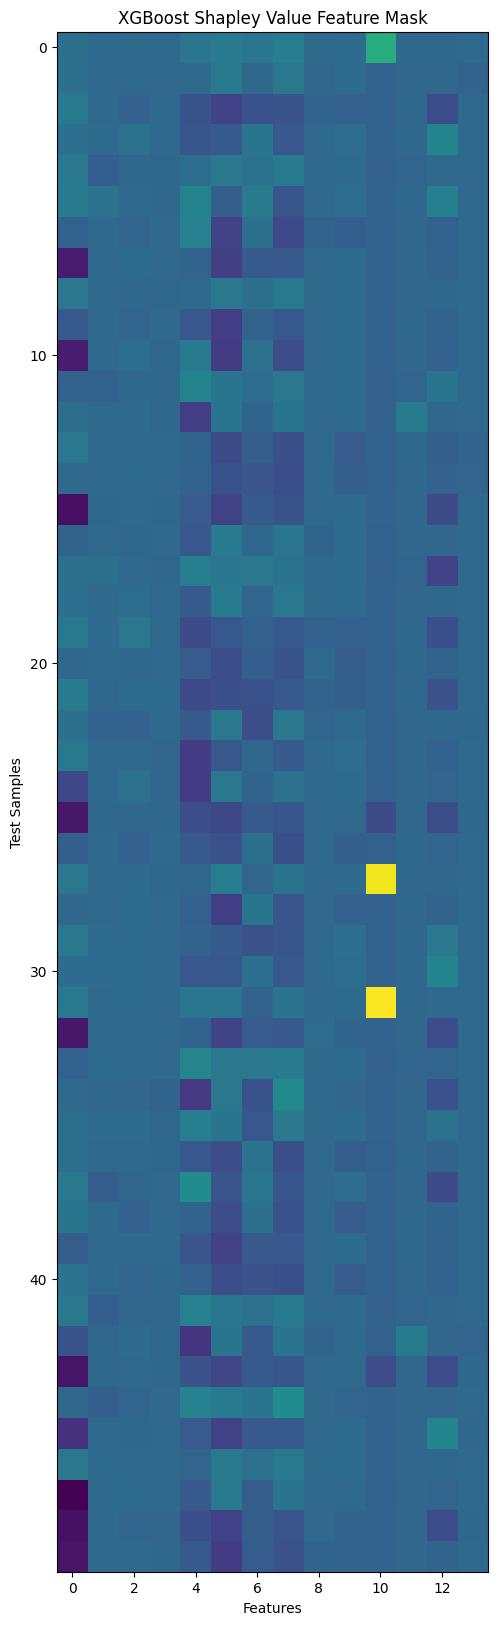

In [37]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(20, 20))
axs.imshow(shap_values[:50])
axs.set_title(f"XGBoost Shapley Value Feature Mask")
axs.set_ylabel("Test Samples")
axs.set_xlabel("Features")
plt.savefig("xgboost_optimized_shapley_mask.png")

## Bar chart of mean importance

This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

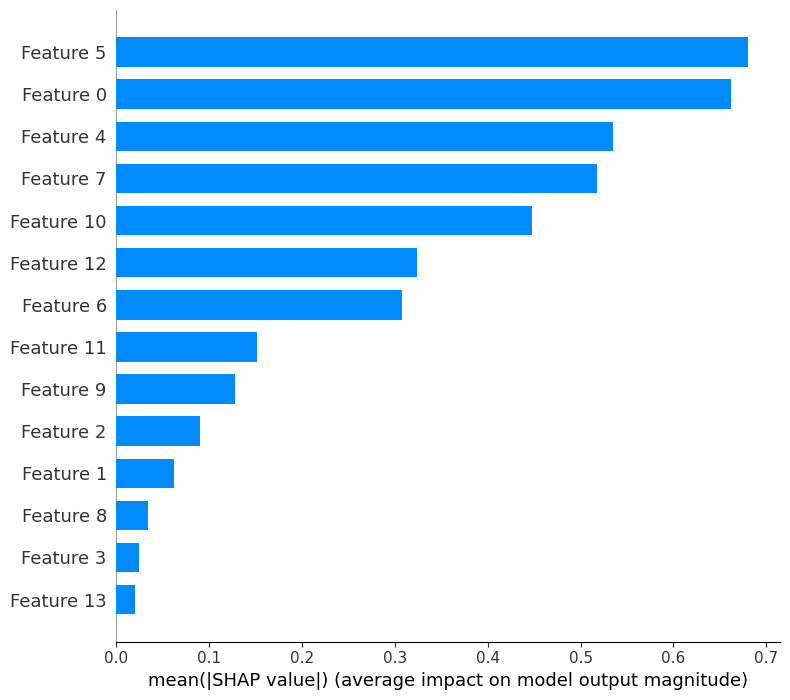

<Figure size 640x480 with 0 Axes>

In [25]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

import matplotlib.pyplot as plt
# shap.summary_plot(shap_values, X_test, show=False)
plt.savefig("xgboost_census_shap_summary_plot.png",dpi=700) #.png,.pdf will also support here

## SHAP Summary Plot

Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the relationship feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age. In other words, capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


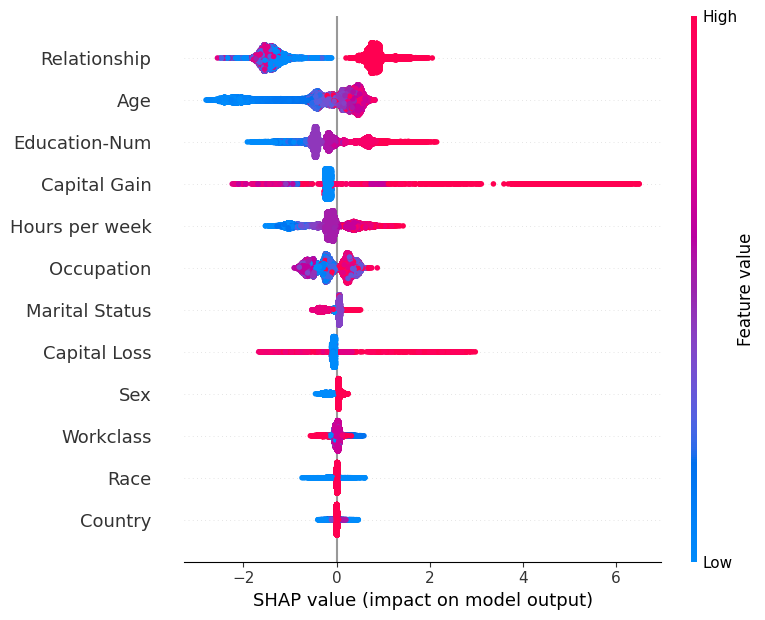

In [ ]:
import matplotlib.pyplot as plt
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig("xgboost_census_shap_summary_plot.png",dpi=700) #.png,.pdf will also support here